In [9]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV
from scipy import stats
from sklearn.linear_model import Ridge


#New Small DF

In [2]:
matchup_df = pd.read_csv("temp_matchupdf.csv")

In [3]:
dftouse=matchup_df.copy()

In [4]:
dftouse.dtypes

AB              int64
H               int64
PA              int64
RL             object
SAC             int64
SO              int64
TB              int64
W               int64
bID            object
matchID        object
pID            object
AVG           float64
OBP           float64
ov_AB           int64
ov_H            int64
ov_PA           int64
ov_SAC          int64
ov_SO           int64
ov_TB           int64
ov_W            int64
ov_FACED        int64
ov_AVG        float64
ov_OBP        float64
ov_SO_PCT     float64
ov_W_PCT      float64
ov_H_PCT      float64
ovp_AB          int64
ovp_H           int64
ovp_PA          int64
ovp_SAC         int64
ovp_SO          int64
ovp_TB          int64
ovp_W           int64
ovp_FACED       int64
ovp_SO_PCT    float64
ovp_W_PCT     float64
ovp_H_PCT     float64
ovp_AVG       float64
ovp_OBP       float64
dtype: object

In [5]:
def compute_supports(df):
    ubids=df.bID.unique()
    pitch = df.groupby('pID').bID.unique()
    bdict={}
    for e,v in zip(pitch.index.values, pitch.values):
        bdict[e] = np.array([item in v for item in ubids])
    pitchers=bdict.keys()
    supports=[]
    for i,p1 in enumerate(pitchers):
        for j,p2 in enumerate(pitchers):
            if  i < j:
                supmask = (bdict[p1] & bdict[p2])
                common_batters = np.sum(supmask)
                supports.append(common_batters)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, bdict

In [6]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all conglomerations recomputed
    this is used when a frame is subsetted.
    """
    ldfb=ldf.groupby('bID')
    ldfp=ldf.groupby('pID')
    nldf=ldf.copy()
    
    #Conglomerate pitcher stats
    nldf.set_index(['pID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ovp_'+col] = ldfp[col].sum()
    nldf['ovp_AVG'] = nldf['ovp_H']/nldf['ovp_AB']
    nldf['ovp_FACED']= ldfp.AB.count()
    nldf['ovp_OBP'] = (nldf['ovp_H'] + nldf['ovp_W'])/nldf['ovp_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ovp_' + col + '_PCT'] = nldf['ovp_' + col] / nldf['ovp_PA']
    nldf.reset_index(inplace=True)
    
    #Conglomerate batter stats
    nldf.set_index(['bID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ov_'+col] = ldfb[col].sum()
    nldf['ov_AVG'] = nldf['ov_H']/nldf['ov_AB']
    nldf['ov_FACED']= ldfb.AB.count()
    nldf['ov_OBP'] = (nldf['ov_H'] + nldf['ov_W'])/nldf['ov_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ov_' + col + '_PCT'] = nldf['ov_' + col] / nldf['ov_PA']
    nldf.reset_index(inplace=True)
    return nldf

In [7]:
def make_smaller(df, pacountp, pacountb):
    smallidf1=df[(df.ovp_PA > pacountp) & (df.ov_PA > pacountb)]
    smalldf=recompute_frame(smallidf1)
    return smalldf

In [8]:
def make_smaller_gen(df, col, limit, greater=True):
    if greater:
        smallidf = df[(df[col] > limit)]
    else:
        smallidf = df[(df[col] < limit)]
    return recompute_frame(smallidf)

In [9]:
#Set minimum number of times batter/pitcher faced each other
smalldf = make_smaller_gen(dftouse, 'PA', 25)

#Set minimum number of total plate appearances for batter and pitcher
smalldf = make_smaller(smalldf, 100, 100)

In [10]:
smalldf.to_csv('small_reduced.csv', index=False)

In [11]:
smalldf.shape

(13179, 39)

In [12]:
smalldf['AVG'] = smalldf['H']/smalldf['AB']
smalldf['OBP'] = (smalldf['H'] + smalldf['W'])/smalldf['PA']

In [96]:
#Copied and pasted over from Baseline model

trainlist=[]
testlist=[]
validatelist=[]
take=21 #21 matchups between validation and test set
for k, v in smalldf.groupby('bID'):
    if len(v) > 100: #batter has faced at least 100 pitchers
        train_rows, test_valid_rows = train_test_split(v, test_size=take)
        trainlist.append(train_rows)
        valid_rows, test_rows = train_test_split(test_valid_rows, test_size=0.4)
        validatelist.append(valid_rows) 
        testlist.append(test_rows) 
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(13095, 39) (48, 39) (36, 39)


#Make the uuids and uiids from the traindf for each batter and pitcher

In [17]:
ubids=traindf.bID.unique()#unique-user-ids
upids=traindf.pID.unique()#unique-item-ids

In [18]:
from sklearn.linear_model import Ridge
features=np.concatenate([ubids,upids])
features.shape

(961,)

In [19]:
traindf.head(10)

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_FACED,ov_AVG,ov_OBP,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT,ovp_AVG,ovp_OBP
829,abreb001,burna001,72,24,86,R,1,20,50,14,abreb001_burna001,0.333333,0.441860,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,2992,767,3342,42,678,1469,350,92,0.202873,0.104728,0.229503,0.256350,0.334231
884,abreb001,willw001,25,9,28,R,1,4,20,3,abreb001_willw001,0.360000,0.428571,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,2502,702,2758,30,373,1486,256,74,0.135243,0.092821,0.254532,0.280576,0.347353
827,abreb001,browk001,36,11,39,R,0,5,19,3,abreb001_browk001,0.305556,0.358974,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,2555,665,2805,23,461,1129,250,71,0.164349,0.089127,0.237077,0.260274,0.326203
836,abreb001,dempr002,29,7,40,R,0,7,16,11,abreb001_dempr002,0.241379,0.450000,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,2381,691,2758,34,448,1350,377,73,0.162437,0.136693,0.250544,0.290214,0.387237
821,abreb001,batim001,33,12,38,R,1,2,23,5,abreb001_batim001,0.363636,0.447368,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,1684,497,1930,33,184,944,246,58,0.095337,0.127461,0.257513,0.295131,0.384974
882,abreb001,washj001,27,3,28,L,0,7,7,1,abreb001_washj001,0.111111,0.142857,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,2620,729,2870,25,360,1475,250,76,0.125436,0.087108,0.254007,0.278244,0.341115
861,abreb001,pavac001,59,20,70,R,2,9,40,11,abreb001_pavac001,0.338983,0.442857,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,1546,480,1661,23,212,917,115,48,0.127634,0.069235,0.288983,0.310479,0.358218
839,abreb001,glavt001,71,17,80,L,0,6,27,9,abreb001_glavt001,0.239437,0.325000,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,5166,1496,5805,58,642,2776,639,114,0.110594,0.110078,0.257709,0.289586,0.367786
842,abreb001,hallr001,41,7,42,R,0,15,9,1,abreb001_hallr001,0.170732,0.190476,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,3914,1051,4187,37,749,1899,273,96,0.178887,0.065202,0.251015,0.268523,0.316217
841,abreb001,guthj001,31,6,34,R,0,4,24,3,abreb001_guthj001,0.193548,0.264706,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,2362,681,2604,32,331,1403,242,66,0.127112,0.092934,0.261521,0.288315,0.354455


In [20]:
#function to produce the design matrix
def getmats(indf):
    
    results_avg = indf['AVG']
    results_obp = indf['OBP']
    
    n_cols = len(features)
    n_rows = len(indf)
    
    #fill matrix with zeros
    mats = np.zeros((n_rows, n_cols))

    #for each element in features, check for match in every row, whether business or user, and switch to one
    for i in range(0, len(ubids)):
        for j in range(0, n_rows):
            if features[i] == indf['bID'].values[j]:
                mats[j, i] = 1
    for i in range(len(ubids), n_cols):
        for j in range(0, n_rows):
            if features[i] == indf['pID'].values[j]:
                mats[j, i] = 1
    return mats, results_avg, results_obp

In [21]:
%%time
designm, avg, obp = getmats(traindf)
testm, test_avg, test_obp = getmats(testdf)

CPU times: user 43.8 s, sys: 281 ms, total: 44.1 s
Wall time: 44.5 s


In [22]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [103]:
%%time

#regressing averages
from sklearn.linear_model import Ridge
alphas = [0.01, 0.1, 10, 100, 1000]
vdict={}
rdict={}
for a in alphas:
    #perform regression for each alpha and store in rdict, keyed by the alpha
    ridge_reg = Ridge(alpha=a)
    
    #we'll do the average for now
    ridge_reg = ridge_reg.fit(designm, avg)
    rdict[a]=ridge_reg
    
    #calculate the RMSE for each alpha, store in vdict
    pred = ridge_reg.predict(validatedm)
    rmse = get_rmse(pred, validate_avg)
    vdict[a]=rmse

Wall time: 3.96 s


In [104]:
vdict

{0.01: 0.089990892259923988,
 0.1: 0.089941138332694334,
 10: 0.089342172492914318,
 100: 0.090642472804778509,
 1000: 0.092723990671586654}

In [105]:
minerroralpha=min(vdict, key=vdict.get)
print minerroralpha
regr=rdict[minerroralpha] 

10


In [106]:
regr.intercept_

0.28034180680573334

The RMSE is a lot smaller here than before. 

#Prediction

In [107]:
testdm, test_avg, test_obp = getmats(testdf)

In [28]:
def compare_results(avg_actual, avg_predicted, ylow=0, yhigh=1, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=np.round(avg_actual, decimals=2), predicted=avg_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 'o-', label="means for %s" % model)
    c=cl.get_color()
    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1,label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,1],[0,1], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        #ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left",prop={'size':23})
    rmse=get_rmse(avg_actual, avg_predicted)
    print "RMSE for %s" % model, rmse
    rmse=3
    return ax,rmse

RMSE for baseline_r 0.0824765971834


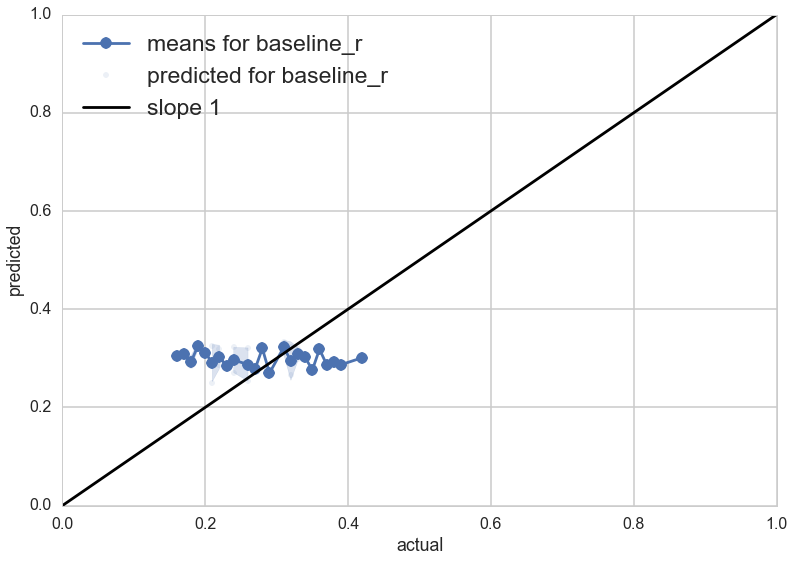

In [109]:
#Comment these out obviously
predictions={}
predictions_valid={}

from sklearn.linear_model import Ridge

pred_test = regr.predict(testdm)
predictions['baseline_r'] = pred_test

pred_valid = regr.predict(validatedm)
predictions_valid['baseline_r'] = pred_valid

compare_results(test_avg,predictions['baseline_r'], model="baseline_r", predicteds=True);

In [ ]:
#ax=plt.gca()
#compare_results(test_avg,predictions['baseline_r'], model="baseline_r", predicteds=True, axis=ax);
#compare_results(testdf.AVG,predictions['baseline'], model="baseline", predicteds=True, onsame=ax);

#Alternative Method: Cross Validation

In [51]:
smalldf=pd.read_csv('data/small.csv')

In [52]:
smalldf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,schic002,benea001,9,0,9,R,1,4,0,0,schic002_benea001,0.000000,0.000000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,3046,827,3425,46,609,1713,379,0.271504,0.352117,136,0.177810,0.110657,0.241460
1,schic002,browk001,11,1,11,R,0,6,1,0,schic002_browk001,0.090909,0.090909,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4582,1159,4989,47,892,1974,407,0.252946,0.313891,222,0.178793,0.081579,0.232311
2,schic002,fassj001,11,2,11,L,1,5,4,0,schic002_fassj001,0.181818,0.181818,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,3006,847,3357,40,582,1587,351,0.281770,0.356866,185,0.173369,0.104558,0.252309
3,schic002,glavt001,14,3,14,L,1,3,5,0,schic002_glavt001,0.214286,0.214286,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,7561,2115,8413,102,985,3852,852,0.279725,0.352668,280,0.117081,0.101272,0.251397
4,schic002,hampm001,16,2,16,L,1,6,2,0,schic002_hampm001,0.125000,0.125000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4782,1361,5339,53,666,2355,557,0.284609,0.359243,232,0.124742,0.104327,0.254917


In [53]:
trainlist=[]
testlist=[]
take=10 #At most 10 matchups in test set
for k, v in smalldf.groupby('bID'):
    train_rows, test_rows = train_test_split(v, test_size=min(take, len(v)/3))
    trainlist.append(train_rows)
    testlist.append(test_rows) 
traindf=pd.concat(trainlist)
testdf=pd.concat(testlist)

In [55]:
%%time
designm, avg, obp = getmats(traindf)
testm, test_avg, test_obp = getmats(testdf)

CPU times: user 5min 52s, sys: 1.5 s, total: 5min 54s
Wall time: 5min 56s


In [56]:
clf = Ridge()
alphas= np.linspace(20, 40, 20)
# Xmatrix_train=traindf[['bID','pID']]
# ymatrix_train=traindf['AVG']
# Xmatrix_test=testdf[['bID','pID']]
# ymatrix_test=testdf['AVG']
# designm, avg
# testm, test_avg

In [57]:
%%time
gs = GridSearchCV(clf, param_grid=dict(alpha=alphas), cv=5)
gs.fit(designm, avg)
best = gs.best_estimator_

CPU times: user 8min 43s, sys: 36.7 s, total: 9min 20s
Wall time: 3min 49s


In [58]:
best

Ridge(alpha=40.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [59]:
clf=best.fit(designm, avg)
training_accuracy = clf.score(designm, avg)
print "BEST: %s" % (gs.best_params_)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.5f" % (training_accuracy)
print "########################################################"

BEST: {'alpha': 40.0}
############# based on standard predict ################
Accuracy on training data: 0.03291
########################################################


In [60]:
predictions = {}

RMSE for baseline_r 0.134634163788


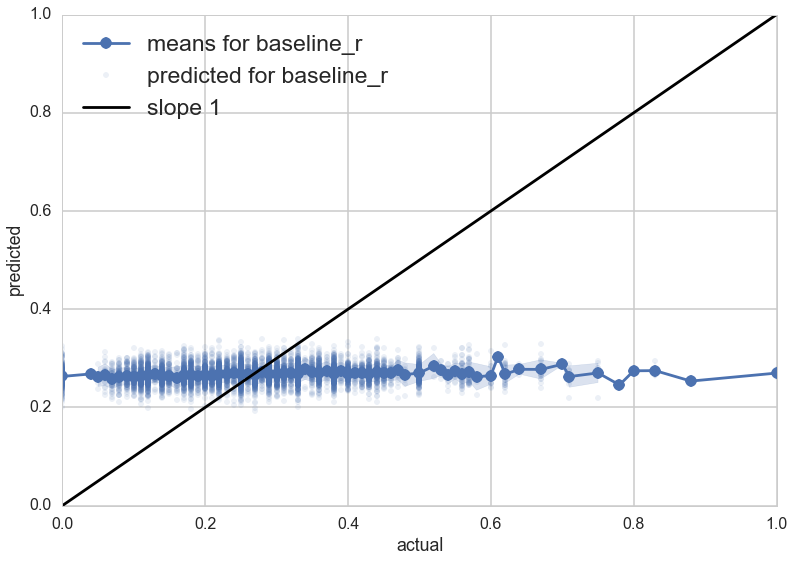

In [61]:
pred_test = best.predict(testm)
predictions['baseline_r'] = pred_test

# pred_valid = regr.predict(validatedm)
# predictions_valid['baseline_r'] = pred_valid

compare_results(test_avg,predictions['baseline_r'], model="baseline_r", predicteds=True);